## 1-3 転移学習の実装

vggの転移学習で自前データ（今回はオープンのやつ）の画像分類モデルつくる  
  
### やること
- dataset作成 
- dataloader作成 (batchごとにデータ取り出す)
- 学習済みモデルの出力層の変更 (転移前とでデータ違う、クラス数も違う、ので)
- 出力層付近のパラメータだけ学習させる (特徴抽出はそのまま)

In [9]:
import glob
import os.path
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
# 乱数設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 1.Dataset作成
### 前処理classつくる  
train, val で処理変える（trainではランダムでdata augmentationしてみる）  

In [3]:
class ImageTransform():
    """
    resize: int or tuple
        リサイズ後のサイズ。tupleなら(h, w)。intなら短辺=resize,長辺はアスペクト比保つように変換。
        transforms.Resize()の実装参照。
    mean: (R, G, B)
        各チャネルの平均。
    std: (R, G, B)
        各チャネルの標準偏差。
    """
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)# input = (input - mean) / std
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
            
    def __call__(self, img, phase="train"):
        # train or val どちらかのComposeに画像渡して処理
        return self.data_transform[phase](img)

処理して見てみる  
(ランダムな処理あるので、実行ごとに結果異なる)

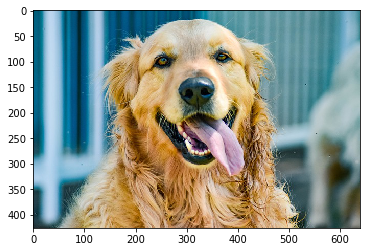

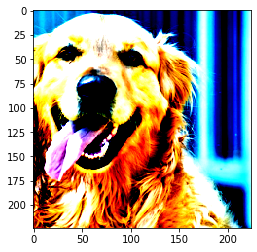

In [8]:
# 画像読み込み
img_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(img_path)

# 元画像表示
plt.imshow(img)
plt.show()

# 前処理
size = 224#vggの入力サイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")# torch.Size([3, 224, 224])

# (c, h, w) を(h, w, c) に変換、画素値を0-1に変換
# 処理後画像表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

### 画像のpathのリスト作る
今回使うデータセット（アリ、ハチ画像）のpathのリスト作る  
（次に作るDataset class に渡したいので）

In [11]:
def make_datapath_list(phase="train"):
    root = "./data/hymenoptera_data/"
    img_path = os.path.join(root, phase, "*", "*.jpg")
    
    path_list = []
    for path in glob.glob(img_path):
        path_list.append(path)
    
    return path_list


train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")


for a in train_list:
    print(a)

./data/hymenoptera_data/train/ants/795000156_a9900a4a71.jpg
./data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg
./data/hymenoptera_data/train/ants/424873399_47658a91fb.jpg
./data/hymenoptera_data/train/ants/2019439677_2db655d361.jpg
./data/hymenoptera_data/train/ants/1804095607_0341701e1c.jpg
./data/hymenoptera_data/train/ants/82852639_52b7f7f5e3.jpg
./data/hymenoptera_data/train/ants/466430434_4000737de9.jpg
./data/hymenoptera_data/train/ants/7759525_1363d24e88.jpg
./data/hymenoptera_data/train/ants/175998972.jpg
./data/hymenoptera_data/train/ants/201558278_fe4caecc76.jpg
./data/hymenoptera_data/train/ants/531979952_bde12b3bc0.jpg
./data/hymenoptera_data/train/ants/trap-jaw-ant-insect-bg.jpg
./data/hymenoptera_data/train/ants/1693954099_46d4c20605.jpg
./data/hymenoptera_data/train/ants/1660097129_384bf54490.jpg
./data/hymenoptera_data/train/ants/255434217_1b2b3fe0a4.jpg
./data/hymenoptera_data/train/ants/512164029_c0a66b8498.jpg
./data/hymenoptera_data/train/ants/1917341202_d

### Dataset class つくる
pytorchのDatasetクラスを継承してつくる  
以下を実装しないといけん  

- `__len__()`:   
 Datasetのファイル数返す  
- `__getitem__()`:   
 Datasetから１つのデータを取り出して返す
（今回は前処理してから画像、labelを返す)

In [13]:
class HymenopteraDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list  # file path のリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase          # train or val の指定
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        # 画像読込
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        # 前処理
        img_transformed = self.transform(img, self.phase)
        
        # ファイル名からlabel("ants" or "bees")を取り出す
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        
        # labelを 0 or 1 で表す
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

In [17]:
size = 224#vggの入力サイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)


train_dataset = HymenopteraDataset(train_list, 
                                  transform=transform,
                                  phase="train")

val_dataset = HymenopteraDataset(val_list,
                                transform=transform,
                                phase="val")

# 確認(一個目のデータ返してもらう)
i = 0
img, label = train_dataset.__getitem__(i)
print(img.size())
print(label)

torch.Size([3, 224, 224])
0


## 2.Dataloader作成
torch.utils.data.DataLoaderつかう  
ミニバッチの塊(?)を何個も返してくれる  
（実装参照、）

In [20]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

# 辞書に入れとく
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


# 確認 (1番目の要素を取り出す)
inputs, labels = next(iter(train_dataloader))
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1])


## 3.学習済modelのロード、出力層の書き換え

In [23]:
# 学習済みvgg16をロード
net = models.vgg16(pretrained=True)

# 出力層書き換え
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# train mode (dropoutとかbatchnormとかに影響する、実装参照)
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 4.損失関数を定義
cross entropy で

In [24]:
criterion = nn.CrossEntropyLoss()

## 5.最適化手法を設定

In [27]:
# 学習させるパラメータを入れるリスト
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ(今回は最後の出力層のweight,bias)以外は勾配計算しない
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print("---------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
---------------
[Parameter containing:
tensor([[-1.1564e-02,  3.2363e-04,  1.1548e-07,  ...,  4.9629e-03,
         -3.3831e-03, -1.0977e-02],
        [ 6.9057e-03,  1.3001e-02,  9.4478e-03,  ...,  1.5176e-02,
          7.6754e-03, -9.6454e-03]], requires_grad=True), Parameter containing:
tensor([-7.5975e-05, -1.0223e-02], requires_grad=True)]


In [29]:
# 最適化手法の設定(SGDで)
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## 6.train, val まわす
epochごとに学習、検証を交互にやる  


In [33]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epoch+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
            
            # 未学習時の検証性能見てみたいので、epoch=0(最初)はtrainなし
            # よって、epoch_num は1-indexでepochを指定する(例：3回回すなら3を指定)
            if epoch == 0 and phase == "train":
                continue
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in dataloaders_dict[phase]:
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):#trainのときだけ勾配計算
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    # lossの合計
                    epoch_loss += loss.item() * inputs.size(0) # loss.item()はミニバッチでの平均なのでサイズかける
                    # 正解数の合計
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # 各epochのphaseごとにloss,正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [35]:
# 実行
num_epoch = 10
train_model(net, dataloaders_dict, criterion, optimizer, num_epoch)

Epoch 0/10
-------------
val Loss: 0.1875 Acc: 0.9412
Epoch 1/10
-------------
train Loss: 0.1321 Acc: 0.9465
val Loss: 0.1235 Acc: 0.9477
Epoch 2/10
-------------
train Loss: 0.1028 Acc: 0.9630
val Loss: 0.1126 Acc: 0.9477
Epoch 3/10
-------------
train Loss: 0.0813 Acc: 0.9753
val Loss: 0.1065 Acc: 0.9477
Epoch 4/10
-------------
train Loss: 0.0851 Acc: 0.9712
val Loss: 0.1030 Acc: 0.9542
Epoch 5/10
-------------
train Loss: 0.0826 Acc: 0.9671
val Loss: 0.1005 Acc: 0.9542
Epoch 6/10
-------------
train Loss: 0.0742 Acc: 0.9753
val Loss: 0.0992 Acc: 0.9477
Epoch 7/10
-------------
train Loss: 0.0723 Acc: 0.9753
val Loss: 0.0997 Acc: 0.9542
Epoch 8/10
-------------
train Loss: 0.0684 Acc: 0.9712
val Loss: 0.0946 Acc: 0.9477
Epoch 9/10
-------------
train Loss: 0.0549 Acc: 0.9753
val Loss: 0.0927 Acc: 0.9477
Epoch 10/10
-------------
train Loss: 0.0503 Acc: 0.9794
val Loss: 0.0913 Acc: 0.9542
